# 使用 SSD 进行 Banana 数据集的目标检测

In [64]:
import torch as pt
from torch import nn
import math
import d2l.torch as d2l
import matplotlib.pyplot as plt

## 基础工作

In [65]:
# 给出图像大小，为图片生成锚框
# 在图片的【每个像素】都生成【若干个】【不同尺寸】的锚框
# 尺寸由 sizes 和 ratios 参数决定
# sizes 定义了锚框面积占图片面积的比例
# ratios 定义了锚框的长宽比。若ratio=1，则锚框为正方形
# 返回 [batch_size][imgh*imgw*锚框数][4]
def multibox_prior(batch_size, img_h, img_w, sizes, ratios):
    sizes = pt.tensor(sizes)
    ratios = pt.tensor(ratios)
    w = pt.sqrt(pt.cat([sizes * ratios[0], sizes[0] * ratios[1:]]) * img_h / img_w) / 2
    h = pt.sqrt(pt.cat([sizes / ratios[0], sizes[0] / ratios[1:]]) * img_w / img_h) / 2
    pos = pt.stack([-w, -h, w, h], dim=1).repeat((img_h*img_w, 1))

    px = pt.arange(0, img_w) + 0.5
    py = pt.arange(0, img_h) + 0.5
    py, px = pt.meshgrid(py, px)
    py = py.reshape(-1) / img_h
    px = px.reshape(-1) / img_w
    pixels = pt.stack([px, py, px, py], dim=1).repeat_interleave(len(sizes) + len(ratios) - 1, dim=0)
    return pt.unsqueeze(pos + pixels, 0).repeat((batch_size, 1, 1))

In [100]:
anchors = multibox_prior(2, 128, 256, [.75, .5, .25], [1., 2, .5])
anchors

tensor([[[-0.3042, -0.6085,  0.3081,  0.6163],
         [-0.2480, -0.4961,  0.2520,  0.5039],
         [-0.1748, -0.3496,  0.1787,  0.3575],
         ...,
         [ 0.8213,  0.6425,  1.1748,  1.3496],
         [ 0.5650,  0.5631,  1.4311,  1.4291],
         [ 0.7815,  0.1301,  1.2146,  1.8621]],

        [[-0.3042, -0.6085,  0.3081,  0.6163],
         [-0.2480, -0.4961,  0.2520,  0.5039],
         [-0.1748, -0.3496,  0.1787,  0.3575],
         ...,
         [ 0.8213,  0.6425,  1.1748,  1.3496],
         [ 0.5650,  0.5631,  1.4311,  1.4291],
         [ 0.7815,  0.1301,  1.2146,  1.8621]]])

In [101]:
anchors = anchors.reshape(-1, 128, 256, 5, 4) #5是一个像素的anchor数量
anchors[0,0,0,:,:]

tensor([[-0.3042, -0.6085,  0.3081,  0.6163],
        [-0.2480, -0.4961,  0.2520,  0.5039],
        [-0.1748, -0.3496,  0.1787,  0.3575],
        [-0.4311, -0.4291,  0.4350,  0.4369],
        [-0.2146, -0.8621,  0.2185,  0.8699]])

In [113]:
# img是图像张量，[通道][height][width]
def show_bboxes(img, bboxes):
    img_h = img.shape[-2]
    img_w = img.shape[-1]
    fig, ax = plt.subplots()
    ax.imshow(img.permute(1, 2, 0))
    for i, bbox in enumerate(bboxes):
        bbox2 = bbox * pt.tensor([img_w, img_h, img_w, img_h])
        rect = plt.Rectangle(xy=(bbox2[0], bbox2[1]), width=bbox2[2]-bbox2[0], height=bbox2[3]-bbox2[1],
                             fill=False, edgecolor='green', linewidth=2)
        ax.add_patch(rect)
        ax.text(rect.xy[0], rect.xy[1], i,
                  va='top', ha='left', fontsize=9, color='k',
                  bbox=dict(facecolor='w', lw=0))

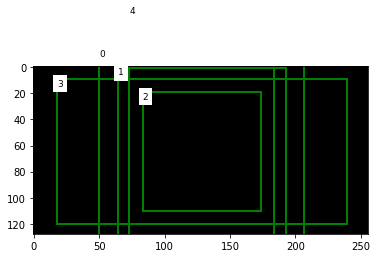

In [114]:
show_bboxes(pt.zeros(3, 128, 256), anchors[0, 64, 128, :, :])

In [103]:
# 计算两个锚框组的iou
# boxes1：[batch][4]
# 返回 [x in boxes1][y in boxes2]表示x和y的iou
def box_iou(boxes1, boxes2):
    box_area = lambda b: (b[:,2]-b[:,0])*(b[:,3]-b[:,1])
    area1 = box_area(boxes1)
    area2 = box_area(boxes2)
    lts = pt.max(boxes1[:, None, :2], boxes2[None, :, :2])
    rbs = pt.min(boxes1[:, None, 2:], boxes2[None, :, 2:])
    inter_wh = (rbs - lts).clamp(min=0)
    inter_area = inter_wh[:,:,0] * inter_wh[:,:,1]
    union_area = area1[:, None] + area2[None, :] - inter_area
    return inter_area / union_area

In [121]:
iou = box_iou(anchors[0,0,0,:3,:], anchors[0,1,1,:3,:])
iou.max(dim=1)

torch.return_types.max(
values=tensor([0.9749, 0.9693, 0.9570]),
indices=tensor([0, 1, 2]))

## SSD

In [3]:
# 返回一个卷积层，层的输入是一个多通道特征图，输出是特征图的各个anchor的分类概率。[batch][num_anchors*(num_classes+1)][row][col]
def class_pred_layer(in_channels, num_anchors, num_classes):
    return nn.Conv2d(in_channels, num_anchors*(num_classes+1), kernel_size=3, padding=1)

In [4]:
def offset_pred_layer(in_channels, num_anchors):
    return nn.Conv2d(in_channels, num_anchors*4, kernel_size=3, padding=1)

In [5]:
Y1 = class_pred_layer(8, 5, 10)(pt.zeros(2, 8, 20, 20))
Y2 = offset_pred_layer(16, 5)(pt.zeros(2, 16, 10, 10))

In [6]:
Y1.shape, Y2.shape

(torch.Size([2, 55, 20, 20]), torch.Size([2, 20, 10, 10]))

In [7]:
# 将预测展平
def flatten_pred(pred:pt.Tensor):
    return pred.permute(0, 2, 3, 1).flatten(start_dim=1)
# 将预测拼接起来
def concat_preds(preds):
    return pt.cat([flatten_pred(pred) for pred in preds], dim=1)

In [8]:
concat_preds([Y1, Y2]).shape

torch.Size([2, 24000])

In [9]:
# 高宽减半层，可以减小特征图尺寸，增大感受野
def down_sample_blk(in_channels, out_channels):
    layers = []
    for _ in range(2):
        layers.append(nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1))
        layers.append(nn.BatchNorm2d(out_channels))
        layers.append(nn.ReLU())
        in_channels = out_channels
    layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)

In [10]:
down_sample_blk(3, 6)(pt.zeros(2, 3, 19, 19)).shape

torch.Size([2, 6, 9, 9])

In [11]:
# 基础网络，用于提取原始图像的特征
# 串联3个高宽减半层，每次通道翻倍
def base_net():
    num_channels = [3, 16, 32, 64]
    layers = []
    for i in range(len(num_channels)-1):
        layers.append(down_sample_blk(num_channels[i], num_channels[i+1]))
    return nn.Sequential(*layers)

In [12]:
base_net()(pt.zeros(2, 3, 256,256)).shape

torch.Size([2, 64, 32, 32])

In [ ]:
# 将ground_truth分配给锚框
# 返回结果 x[i] 表示第 i 个锚框对应的ground truth下标
def assign_gt_to_anchor(ground_truth, anchors, iou_threshold=0.5):
    iou = box_iou()